In [84]:
## run t test on the harmonic features (entropy of the spectrum power histogram)

from scipy import stats
import pandas as pd
import numpy as np
import os
import re
import glob
import seaborn as sns
import matplotlib.pyplot as plt

input_dir = 'adni_out04_power_histogram_and_entropy'
output_dir = 'adni_out05_ttest'

if not os.path.exists(output_dir):
    os.mkdir(output_dir)

PTGENDER  DX  
Female    AD      17
          CN      50
          EMCI    43
          LMCI    28
          SMC     23
Male      AD      16
          CN      44
          EMCI    42
          LMCI    31
          SMC     17
dtype: int64


TypeError: boxplot() got multiple values for keyword argument 'positions'

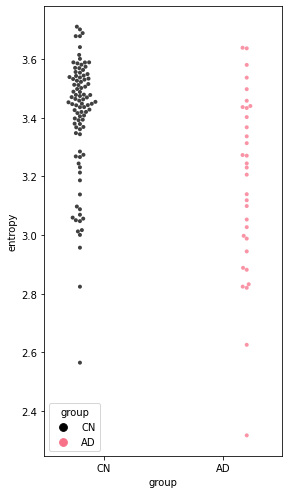

In [91]:
data_files = glob.glob(input_dir + '/adni_out04_entropy_freq_*.csv')
data_files.sort()

# all_result = []
print_group_size = True

comparision = [('CN', 'AD'), ('CN', 'EMCI'), ('CN', 'LMCI'), ('CN', 'SMC')]
result_pvalue_allfreq = []
result_stat_allfreq = []

for f in data_files:
    
    result_pvalue = {comp: [] for comp in comparision}
    result_stat = {comp: [] for comp in comparision}
    
    #print(f)
    freq = re.search('(.*)_freq_(.*).csv', f).group(2)
    data = pd.read_csv(f, index_col = 0)
    data.dropna(subset=['DX'], inplace = True)
    
    if print_group_size:
        print(data.groupby(['PTGENDER', 'DX']).size())
        print_group_size = False
    
    for feature in range(264):
        
        for comp in comparision:
            # select data with ad/lmci and cn:    
            group1 = data.loc[data['DX'].isin([comp[0]]), str(feature)].values
            group2 = data.loc[data['DX'].isin([comp[1]]), str(feature)].values

            ttest = stats.ttest_ind(group1, group2, equal_var = False)
            
            result_pvalue[comp].append(ttest.pvalue)
            result_stat[comp].append(ttest.statistic)
            
            ## box plot for each brain region:
            a4_dims = (4.27, 8.27)
            fig, ax1 = plt.subplots(figsize=a4_dims)

            plot_data = pd.concat([pd.DataFrame({'entropy': group1, 'group': comp[0]}), 
                                   pd.DataFrame({'entropy': group2, 'group': comp[1]})], axis = 0)

            colors = [sns.xkcd_rgb["black"]] + sns.color_palette("husl", 6).as_hex()
            colors = colors[:2]

            sns.swarmplot(y = "entropy", x = "group", data = plot_data, 
                           hue = 'group', dodge=True, facecolors='none',
                           palette = colors, #plot_kws={'scatter_kws': {'alpha': 0.1}}
                           alpha = .75, size=4,
                         ax = ax1)

            sns.boxplot(y = "entropy", x = "group", data = plot_data, 
                         hue = 'group', palette = colors,
                         notch = True,
                       ax = ax1)
            
            c = ax.collections
            group_label = comp
            ax.legend(c[:4], #the last n handles are for the legend. this is strange [-n:] does not work but [n:] works...
               group_label, 
               borderaxespad = 0., 
               loc = 'right', 
               columnspacing = 1.2,
               frameon = False, markerscale = 3, handlelength = .1,
               prop = {'size': 25}, title = '', bbox_to_anchor=(1, 1.1), ncol=2)
            
            ## change boxplot style:
            for i, artist in enumerate(ax1.artists):
                # Set the linecolor on the artist to the facecolor, and set the facecolor to None
                col = artist.get_facecolor()
                artist.set_edgecolor(col)
                artist.set_facecolor('None')

                # Each box has 6 associated Line2D objects (to make the whiskers, fliers, etc.)
                # Loop over them here, and use the same colour as above
                for j in range(i*6,i*6+6):
                    line = ax1.lines[j]
                    line.set_color(col)
                    line.set_mfc(col)
                    line.set_mec(col)
            break

            result_pvalue_allfreq.append(result_pvalue)
            result_stat_allfreq.append(result_stat)
        break
    break

print('finished')


In [56]:
for comp in comparision:
        res = pd.DataFrame([result_pvalue[comp] for result_pvalue in result_pvalue_allfreq])
        res = res.transpose()
        res.index = ['roi' + str(i) for i in range(1, 265)]
        res.columns = ['freq' + str(i) for i in range(1, 11)]

        res.to_csv(output_dir + '/lasso_pvalue_' + comp[0] + '_' + comp[1] + '.csv')

        res = pd.DataFrame([result_stat[comp] for result_stat in result_stat_allfreq])
        res = res.transpose()
        res.index = ['roi' + str(i) for i in range(1, 265)]
        res.columns = ['freq' + str(i) for i in range(1, 11)]

        res.to_csv(output_dir + '/lasso_stats_' + comp[0] + '_' + comp[1] + '.csv')

In [53]:
res

,freq1,freq2,freq3,freq4,freq5,freq6,freq7,freq8,freq9,freq10
roi1,0.957764,1.372865,0.539440,1.211955,2.098220,1.593292,-1.303119,0.813325,0.940397,0.296921
roi2,0.559545,0.166827,0.103028,1.187458,0.725561,0.767181,0.964595,2.172710,0.916655,0.594828
roi3,1.128403,1.096513,-0.278928,-0.859202,1.346481,-0.288389,-0.231284,1.446892,0.462875,0.276606
roi4,0.773806,0.363649,-0.214714,1.932513,0.598217,-0.060398,-0.119582,0.972603,0.068195,-0.418270
roi5,1.354377,-0.522578,0.748084,1.726530,0.141882,1.173359,0.766351,1.292599,0.607396,0.020005
...,...,...,...,...,...,...,...,...,...,...
roi260,1.633170,1.062636,1.573354,1.988026,0.015313,1.834826,0.978935,-0.025414,0.036348,-0.305709
roi261,-0.111105,-0.138090,-0.384108,-0.204251,0.304999,0.008762,-1.064237,0.544269,-0.129577,-0.063829
roi262,-0.215975,0.378196,0.341264,0.408450,-0.276452,-1.186170,1.404313,0.196927,1.708893,0.050733
roi263,-0.561742,-0.422365,0.636922,0.469304,0.782548,0.620884,-1.998601,0.723845,-0.125189,-0.722547
